In [1]:
# Import 

#Import linear algebra and data manipulation
import numpy as np
import pandas as pd

#Import plotting packages
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#Import machine learning
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split #split
from sklearn.metrics import r2_score, mean_squared_error #metrics


# Introduction 
### From the user point of view, user are always concerned the reservation fee of Airbnb. Here is interesting analysis and report to show all of the Airbnb users who may plan to visit Seattle.
   - What are factors affect the seattle reservation fee ?
   - What is the peak season or month to visit Seattle ?
   - How can user save money on the reservation fee ?

# High-level overview of Airbnb reservation price
### The information is according to Airbnb Offical Website

- ##### The reservation price includes four main portions and additional cost

    - Nigltly prices: Depend on how many nights you are staying and charged by host.
    - Cleaning fee: One-time fee charged by host to cover the cost of cleaning their space.
    - Service fee: Airbnb service fee. Offer services like 24/7 support on your trip.
    - Occupancy taxes and fees: Transient Occupancy Tax 
    - Additional cost: extra guest fees, security deposit, VAT charges on service fees etc.

# How much should you charge someone to live in your house?
- ##### Airbnb has algorithms to set or suggest prices.(https://www.vrmintel.com/inside-airbnbs-algorithm/)
- ##### Key Factors Affecting Airbnb Host Pricing
    - Time of travel: Peak season or low season; early brid discount deal. 
    - Amenities: WiFi, TV, Swimming pool etc. 
    - Neighbourhood: if close enough to downtown or attractions, any transportation around such as subway or train station 

# Scenario
###    1.Data exploration: 
        - What information we have?
        - Any missing information?
        - Investigate potential factors: time period in calendar dataset, total number of listings in listing dataset
###    2.Scrub Data(Clean Dataset):
        - remove the irrelevant data
        - reformat the data and replace missing value
###    3.High-level analysis
        - What are high level trends and correlations
###    4.Machine Learning 
###    5.Recap

## Data exploration
- Airbnb Seattle provided 3 datasets 
  - listings.csv: summarized the Seattle listing information such as location, host information, cleaning and guest fees, amenities etc.
  - calendar.csv: summarized availability dates, price for each date.
  - reviews.csv : summarized review data for the listings. This dataset won't be used in further analysis.

In [2]:
# read the dataset listing 
listings = pd.read_csv('listings.csv')
# inspect the listings dataframe
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [3]:
#find number of listings and number of hosts
listings_num = listings['id'].count()
hosts_num = len(listings['host_id'].unique())

print('Listing dataset has information on %d listings provided by %d hosts.' % (listings_num, hosts_num))

Listing dataset has information on 3818 listings provided by 2751 hosts.


Text(0, 0.5, '%')

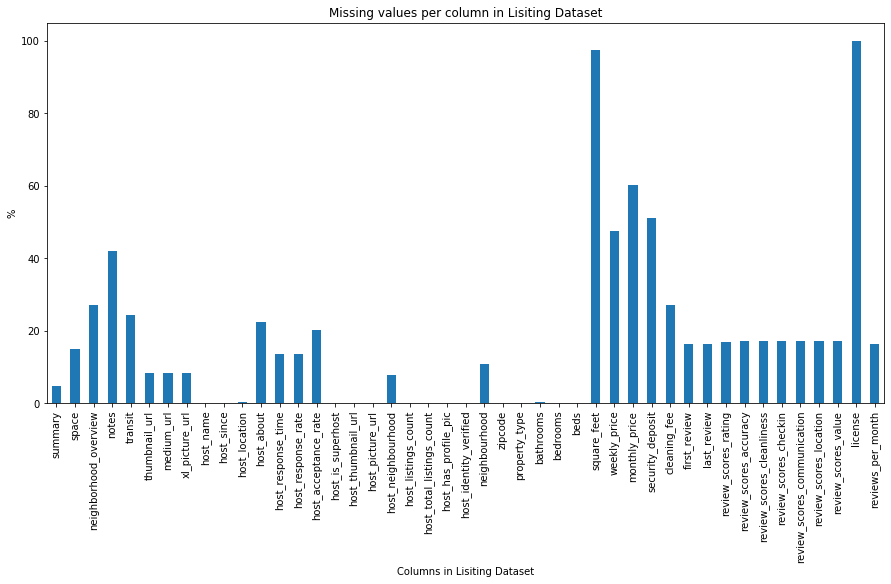

In [4]:
#find percentage of missing values for each column
listings_missing= listings.isnull().mean()*100

#filter out only columns, which have missing values
listings_columns_with_nan = listings_missing[listings_missing > 0]

#plot the results
listings_columns_with_nan.plot.bar(title='Missing values per column in Lisiting Dataset',figsize=(15, 7))
plt.xlabel('Columns in Lisiting Dataset')
plt.ylabel('%')

As the bar chart shown above, the values of listing license and square feet were missing. Also, there are more than 40 % missing values in weekly price, monthly price and security deposit columns which would not be include in the analysis report because of overfitting in Machine Learning.

In [5]:
# read the calendar dataset
calendar = pd.read_csv('calendar.csv')
# inspect the calendar dataframe
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [6]:
#find number of rows in dataset
rows_total = len(calendar.index)

#find the earliest and last date of the calendar
earliest_date = calendar['date'].min()
last_date = calendar['date'].max()

print('Calendar dataset has %d rows.' % (rows_total))
print('The first date in Calendar Dataset is %s and the last date is %s.' % (earliest_date, last_date))


Calendar dataset has 1393570 rows.
The first date in Calendar Dataset is 2016-01-04 and the last date is 2017-01-02.


Text(0, 0.5, '%')

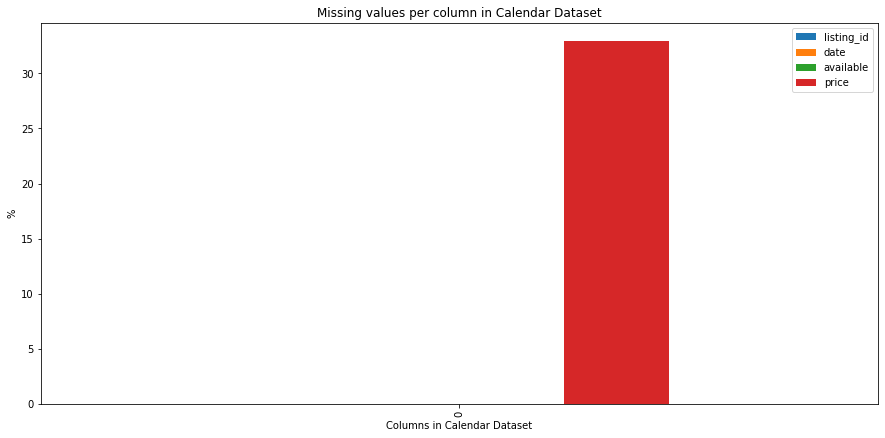

In [7]:
#find percentage of missing values for each column
calendar_missing = pd.DataFrame([calendar.isnull().mean()*100])

#plot the results
calendar_missing.plot.bar(title='Missing values per column in Calendar Dataset',figsize=(15, 7))
plt.xlabel('Columns in Calendar Dataset')
plt.ylabel('%')

As the bar chart shown above, there are roughly 32 % of missing values in price column for dates when the listing was unavailable.

## Scrub Data(Clean Dataset)
- Merged lisiting and calendar dataset into one 
- Removed irrelevant columns and missing values 
- Converted dates and prices datatype into numbers 

In [8]:
#Helper functions for dataset cleaning

def get_month_from_date(row):
    ''' Get month from date represented as a string '''
    return int(row['date'].split('-')[1])

def get_year_from_date(row):
    ''' Get year from date represented as a string '''
    return int(row['date'].split('-')[0])

def get_host_since_year(row):
    ''' Get year from a date represented as a string '''
    try:
        host_since = int(row['host_since'].split('-')[0])
    except:
        host_since = np.nan
    return host_since

def get_val_from_list(row, column_name, value):
    ''' Fill in dummy column for values '''
    val = 0.0
    try:
        vals = row[column_name].replace('[', '').replace("'", '').replace("]", '').replace('"', '').replace('{', '').replace('}', '').split(',')
        if value in vals:
            val = 1.0
    except:
        val = 0.0
    return val

def split_list_into_columns(df, column_name, max_dummies_num = 10):
    ''' Split values in columns, which contain lists (for example, amenities) '''
    
    # get dictionary of unique values in lists across dataset rows
    values_dict = {}

    for unique_value in df[column_name].unique(): 
        for value in unique_value.replace('[', '').replace("'", '').replace("]", '').replace('"', '').replace('{', '').replace('}', '').split(','):
            if value in values_dict:
                values_dict[value] = values_dict[value] + 1
            else:
                values_dict[value] = 0
                
    values_sorted = sorted(values_dict.items(), key=lambda kv: kv[1], reverse = True)
      
    # split into columns
    for value in values_sorted[: max_dummies_num]:
        df[column_name + '_' + value[0]] = df.apply(lambda row: get_val_from_list(row, column_name, value[0]),axis=1)
        
    return

def get_extra_people_fee(row):
    ''' Return 1 when the is fee for exatra people '''
    if row['extra_people'] == '$0.00':
        return 0.0
    else:
        return 1.0

#Main dataset cleaning function
def clean_dataset(listings_df, calendar_df):
    '''
    INPUT
    listings_df - pandas dataframe containing listings data 
    calendar_df - pandas dataframe containing calendar data
    
    OUTPUT
    df - cleaned dataset, which contains merged tables:
    1. irrelevant columns are dropped;
    2. string containing dates are converted into numbers;
    3. columns, containing lists, are split into several columns (for example, amenities)
    4. missing values are imputed with mean or mode.
    '''
    #merge datasets
    listings_df = listings_df.rename(index=str, columns={"id": "listing_id"})
    df = pd.merge(calendar_df, listings_df, on = 'listing_id')
    
    #drop the irrelevant columns
    columns_to_drop = ['available', 'host_id','host_location','host_acceptance_rate','host_neighbourhood',
                   'host_total_listings_count', 'weekly_price', 'monthly_price',
                   'security_deposit', 'cleaning_fee', 'calendar_updated',
                   'listing_url','last_scraped' ,'scrape_id', 'name', 'summary', 'space', 'description',
                   'experiences_offered', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'zipcode',
                   'neighborhood_overview', 'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
                   'xl_picture_url', 'host_url', 'host_name', 'host_about', 'host_thumbnail_url', 'host_picture_url',
                   'city', 'state', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude',
                   'is_location_exact', 'square_feet', 'has_availability', 'availability_30',
                   'availability_60', 'availability_90', 'availability_365', 'calendar_last_scraped',
                  'first_review', 'last_review', 'requires_license', 'license', 'jurisdiction_names', 'price_y',
                  'reviews_per_month']
    df = df.drop(columns = columns_to_drop)
    
    #convert date from the calendar into month and drop the date colum
    df['month'] = df.apply(lambda row: get_month_from_date(row),axis=1)
    df['year'] = df.apply(lambda row: get_year_from_date(row),axis=1)
    df = df.drop(columns = ['date'])
    
    #remove rows where price_x == nan, because price will be used as response column
    df = df.dropna(subset=['price_x'])
    
    #convert price to number and drop the price_x column
    df['price'] = df['price_x'].astype(str)
    df['price'] = df['price'].str.replace("[$, ]", "").astype("float")
    df = df.drop(columns = ['price_x'])
    
    #convert host_since date into number and fill in missing values, drop the original column
    df['host_since_year'] = df.apply(lambda row: get_host_since_year(row),axis=1)
    df['host_since_year'].fillna(df['host_since_year'].mean(), inplace = True)
    df = df.drop(columns = ['host_since'])
    
    #convert host_response_rate into number and fill in missing values, drop the original column
    df['host_response_rate_num'] = df['host_response_rate'].astype(str)
    df['host_response_rate_num'] = df['host_response_rate_num'].str.replace("%", "").astype("float")
    df['host_response_rate_num'].fillna(df['host_response_rate_num'].mean(), inplace = True)
    
    df['host_response_rate_buckets'] = pd.qcut(df['host_response_rate_num'], 5, labels=False, duplicates = 'drop')
    
    df = df.drop(columns = ['host_response_rate', 'host_response_rate_num'])
    
    #fill missing values with mean value for host_listings_count
    df['host_listings_count'].fillna(df['host_listings_count'].mean(), inplace = True)
    
    #split host_verifications into dummy columns and drop the original column
    split_list_into_columns(df, 'host_verifications')
    df = df.drop(columns = ['host_verifications'])
    
    #fill in missing values for bathrooms, bedrooms and beds with mode
    df['bathrooms'] = df['bathrooms'].fillna(df['bathrooms'].mode()[0])
    df['bedrooms'] = df['bedrooms'].fillna(df['bedrooms'].mode()[0])
    df['beds'] = df['beds'].fillna(df['beds'].mode()[0])
    
    #split amenities into dummy columns and drop the original column
    split_list_into_columns(df, 'amenities')
    df = df.drop(columns = ['amenities'])
    
    #turn extra people fee into binary column (1 - if fee for extra people is charged, 0 - otherwise)
    df['extra_people_fee'] = df.apply(lambda row: get_extra_people_fee(row),axis=1)
    df = df.drop(columns = ['extra_people'])
    
    #fill missing values for review scores columns
    review_scores_columns = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
                         'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
                        'review_scores_value']
    for column in review_scores_columns:
        df[column].fillna(df[column].mean(), inplace = True)
    
    return df

In [9]:
# apply functions above to clean dataset
df = clean_dataset(listings, calendar) 
df.head()


,listing_id,host_response_time,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,property_type,room_type,accommodates,...,amenities_Heating,amenities_Kitchen,amenities_Smoke Detector,amenities_Essentials,amenities_Dryer,amenities_Washer,amenities_Internet,amenities_Shampoo,amenities_TV,extra_people_fee
0,241032,within a few hours,f,3.0,t,t,Queen Anne,Apartment,Entire home/apt,4,...,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0
1,241032,within a few hours,f,3.0,t,t,Queen Anne,Apartment,Entire home/apt,4,...,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0
9,241032,within a few hours,f,3.0,t,t,Queen Anne,Apartment,Entire home/apt,4,...,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0
10,241032,within a few hours,f,3.0,t,t,Queen Anne,Apartment,Entire home/apt,4,...,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0
14,241032,within a few hours,f,3.0,t,t,Queen Anne,Apartment,Entire home/apt,4,...,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0


In [15]:
#export the cleaned dataset for tableau graphing use
from IPython.display import FileLink, FileLinks
df.to_csv(r'seattle_cleaned_airbnb_dataset.csv')

### High Level Analysis
- With clean data, we can use it to answer our initial questions

#### High level overview  of Seattle listing prices

In [10]:
#find minimum, maximum and average price for listing
min_price = df['price'].min()
max_price = df['price'].max()
mean_price = df['price'].mean()
median_price = df['price'].median()


print('Minimum price per listing is $%d.' % (min_price))
print('Maximum price per listing is $%d' % (max_price))
print('Average price per listing is $%d.' % (mean_price))
print('Median price per listing is $%d.' % (median_price))

Minimum price per listing is $10.
Maximum price per listing is $1650
Average price per listing is $137.
Median price per listing is $109.


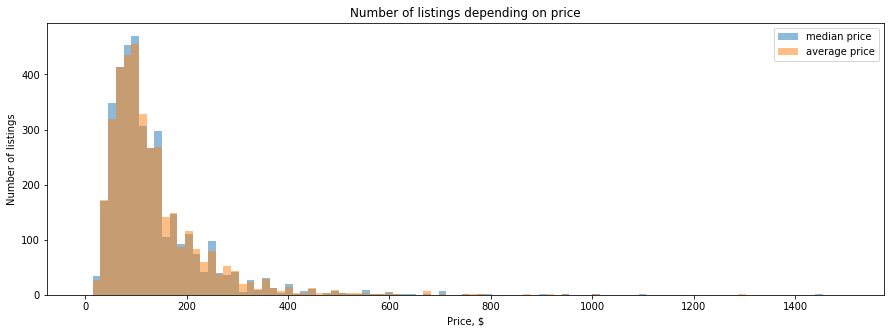

In [11]:
# get the median price for each listing
median_price_for_each_listing = df.groupby('listing_id')['price'].median()
average_price_for_each_listing = df.groupby('listing_id')['price'].mean()

#plot
plt.figure(figsize=(15,5))
bins = np.linspace(0, 1500, 100)
plt.hist(median_price_for_each_listing, bins, alpha=0.5, label='median price')
plt.hist(average_price_for_each_listing, bins, alpha=0.5, label='average price')
plt.legend(loc='upper right')
plt.ylabel('Number of listings')
plt.xlabel('Price, $')
plt.title('Number of listings depending on price')

plt.savefig('Price distrubution.png')

plt.show()

As the distribution of average and median listing prices shown above, the major listing prices is around 50 to 150 USD which is corresponded to the average price: 137 USD and median price: 109 USD.

### What is the peak season or month to visit Seattle ?
1. We will take a look the listing numbers of each month in 2016
2. and the prices difference of each month in 2016

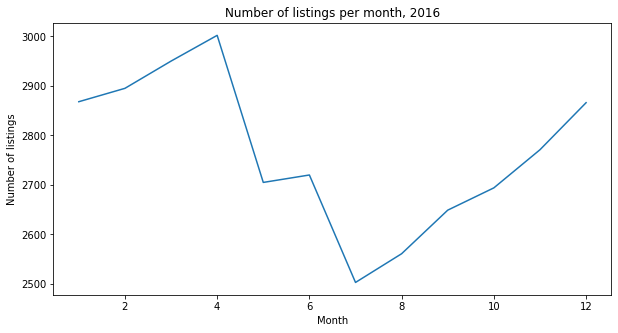

In [12]:
#find number of total number of listings for each month in 2016
df_2016 = df.loc[df['year'] == 2016]

number_of_listings_by_month = df_2016.groupby(['month'])['listing_id'].nunique()
#plot
plt.figure(figsize=(10,5))
plt.plot(number_of_listings_by_month)
plt.ylabel('Number of listings')
plt.xlabel('Month')
plt.title('Number of listings per month, 2016')


plt.show()


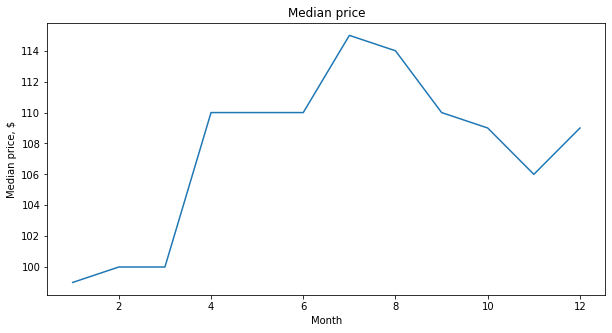

In [13]:
#find average price by month
median_price_by_month = df.groupby(['month'])['price'].median()

#plot
plt.figure(figsize=(10,5))
plt.plot(median_price_by_month)
plt.ylabel('Median price, $')
plt.xlabel('Month')
plt.title('Median price')

plt.savefig('Median price for month')

plt.show()

The Number of listings per month diagram shows us the number of listings depending on month.The number of available listings for reservation is tends to be the highest in summer. Therefore, the median price diagram shows that listing prices rairse the peak between June to August and there's another peak in December as well. This tells us the lower number of the listings on the market has higher median price and due to the median price diagram the summer and winter are peak season to visit Seattle. 

### Prices Difference based on Neighborhood

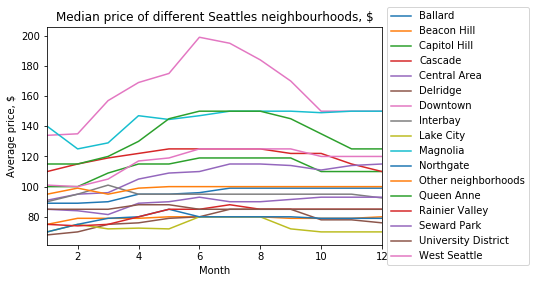

In [14]:
price_by_month_neighbourhood = df.groupby(['month','neighbourhood_group_cleansed'])['price'].median().unstack()

price_by_month_neighbourhood.plot.line().legend(loc='center left',bbox_to_anchor=(1.0, 0.5));

plt.ylabel('Average price, $')
plt.xlabel('Month')
plt.title('Median price of different Seattles neighbourhoods, $')

plt.show()


As the diagram of Median price of different Seattles' neighbourhoods, the highest median prices are in Downtown. Another intesting data shown above, summer has a higher average prices compared to others seasons. 

### Correlation between Prices and Factors 
- At here, we will investigate what are others factors affect the listing prices 
- Used the heatmap to find out correlation between prices and other factors 

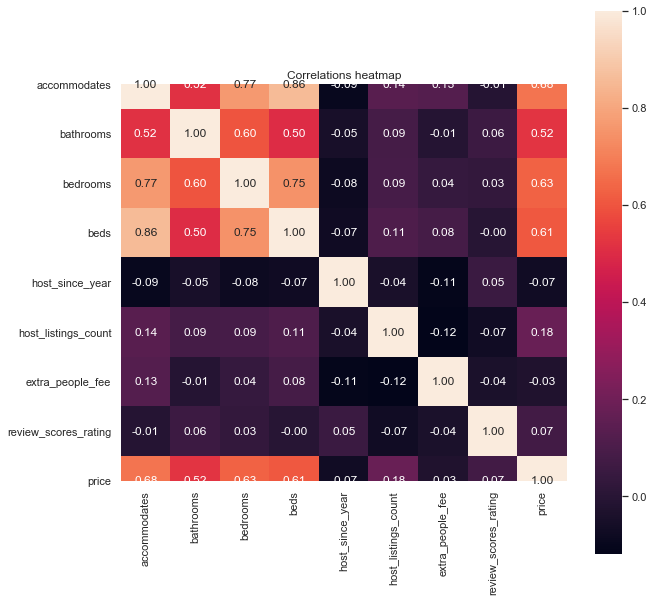

In [15]:
cols = ['accommodates','bathrooms','bedrooms','beds','host_since_year',
        'host_listings_count', 'extra_people_fee',
        'review_scores_rating', 'price']

#Find out correlation between columns and plot
corrs = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1)
sns.set(rc={'figure.figsize':(10,10)})
hm=sns.heatmap(corrs, cbar = True, annot=True, square = True, fmt = '.2f',
              yticklabels = cols, xticklabels = cols).set_title('Correlations heatmap')

fig = hm.get_figure()
fig.savefig('correlations.png')

Through correlation heatmap, the price is correlated with the number of bathrooms, bedrooms, and beds. Obviously, the lisiting prices depends on the size of the accommodation.

### Machine Learning 
- Used machine learning methods to tell what features in dataset affect the price the most.
    - Train a model by Random Forest Regressor 

In [16]:
#turn categorical columns into dummies
cat_columns = list(df.select_dtypes(include=['object']).columns)
    
for col in  cat_columns:
    df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_',

                                                         drop_first=True, dummy_na=True)], axis=1)
#drop listing_id and year columns
df = df.drop(columns = ['listing_id', 'year'])

In [17]:
#prepare train and test datasets for modelling
TEST_SIZE = 0.3
RAND_STATE = 42

X = df.drop(columns = 'price')
y = df[['price']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SIZE, random_state=RAND_STATE)

In [18]:
#train RF regressor model
forest = RandomForestRegressor(n_estimators=100, 
                               criterion='mse', 
                               random_state=RAND_STATE, 
                               n_jobs=-1)
forest.fit(X_train, y_train.squeeze())

#calculate scores for the model
y_train_preds = forest.predict(X_train)
y_test_preds = forest.predict(X_test)

print('Random Forest MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_preds),
        mean_squared_error(y_test, y_test_preds)))
print('Random Forest R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_preds),
        r2_score(y_test, y_test_preds)))

Random Forest MSE train: 186.973, test: 211.258
Random Forest R^2 train: 0.983, test: 0.981


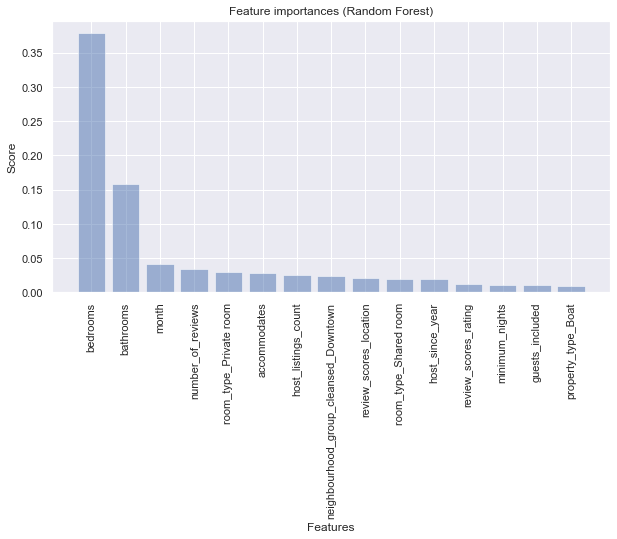

In [19]:
#get feature importances from the model
headers = ["name", "score"]
values = sorted(zip(X_train.columns, forest.feature_importances_), key=lambda x: x[1] * -1)
forest_feature_importances = pd.DataFrame(values, columns = headers)
forest_feature_importances = forest_feature_importances.sort_values(by = ['score'], ascending = False)

features = forest_feature_importances['name'][:15]
y_pos = np.arange(len(features))
scores = forest_feature_importances['score'][:15]

#plot feature importances
plt.figure(figsize=(10,5))
plt.bar(y_pos, scores, align='center', alpha=0.5)
plt.xticks(y_pos, features, rotation='vertical')
plt.ylabel('Score')
plt.xlabel('Features')
plt.title('Feature importances (Random Forest)')

plt.savefig('feature importances RF.png')
 
plt.show()

Let's take a look at the results of the modelling:

The modelling also shows us that factors already mentioned above have influence on price: time of the year, location, number of bedrooms, bathrooms, beds and accomodates;
The host qualities are important: number of host's listings, number of years since being the host, time in which the host responds to the inquiries;
The pricing might depend on reviews: number of reviews and review scores.